<img src="./logo_UTN.svg" align="right" width="150" /> 


<br><br>
#### Procesamiento Digital de Señales

# Trabajo Práctico Nº4
#### Alumno:    Fernando Daniel Fiamberti

# <span style="color:Blue">Introducción</span>
###   Primeras nociones de estimación espectral: Ancho de banda de señales.
 
# <span style="color:Blue">Enunciado</span>
## Consignas:

### En el repositorio PDStestbench encontrará tres tipos de señales registradas:

***Electrocardiograma (ECG).*** En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.

***Pletismografía (PPG).*** El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.

***Audio.*** Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

***Se pide:***

***1)*** Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

***2)*** Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

***Bonus:***

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.



# Desarrollo de la tarea

## BONUS:  señal de 440Hz pura, bajada de una página de internet

### <span style="color:Blue">Código implementado:</span>


C:\Users\Logo\AppData\Local\Temp\ipykernel_19384\29445252.py:29: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal_full = wavfile.read(wav_file)


Se usarán todas las 220500 muestras del 440Hz para el análisis
Frecuencia de muestreo: 44100 Hz


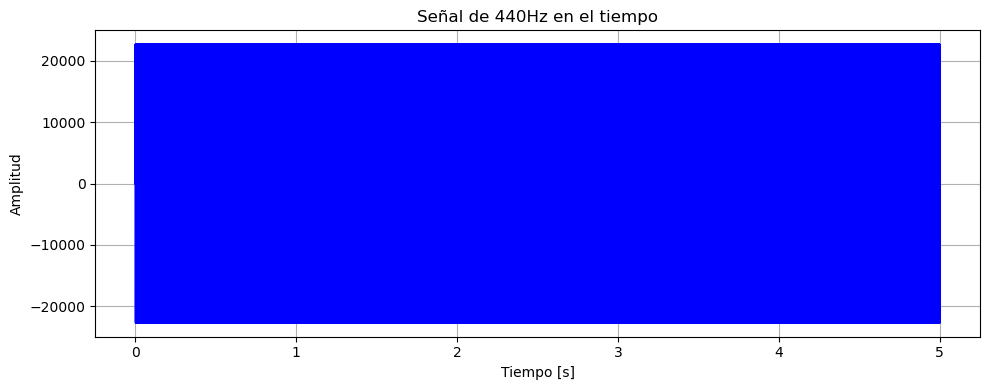

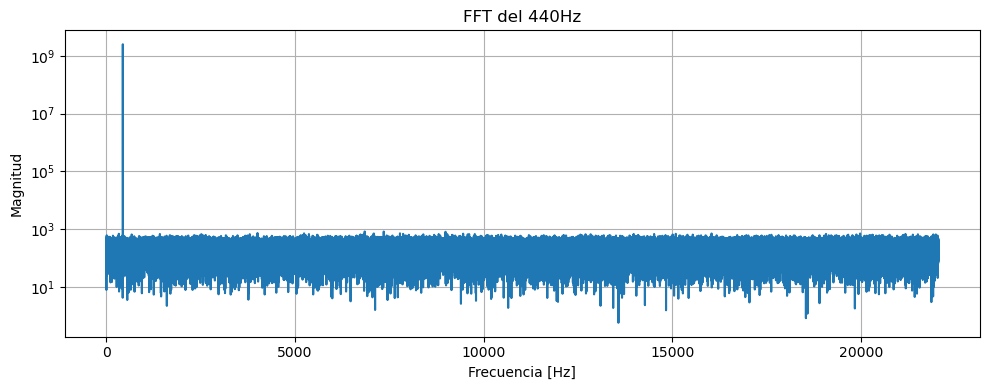

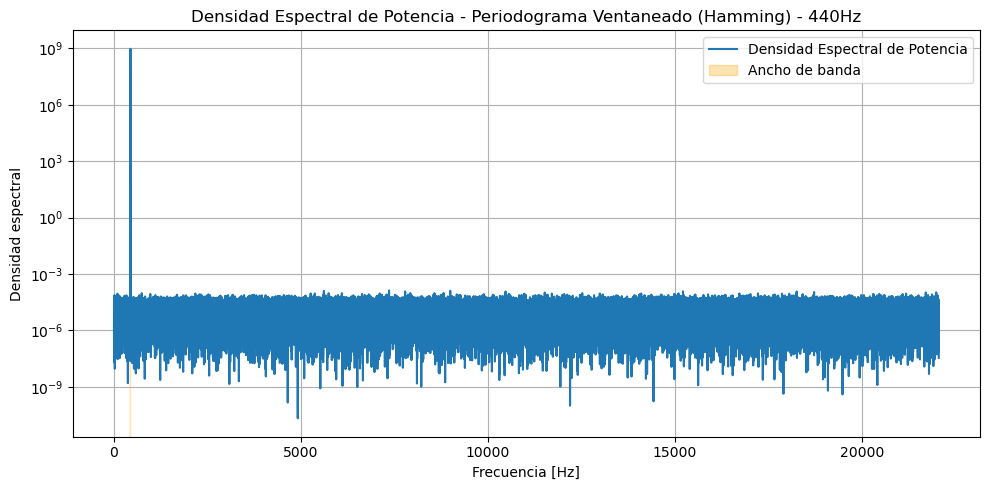

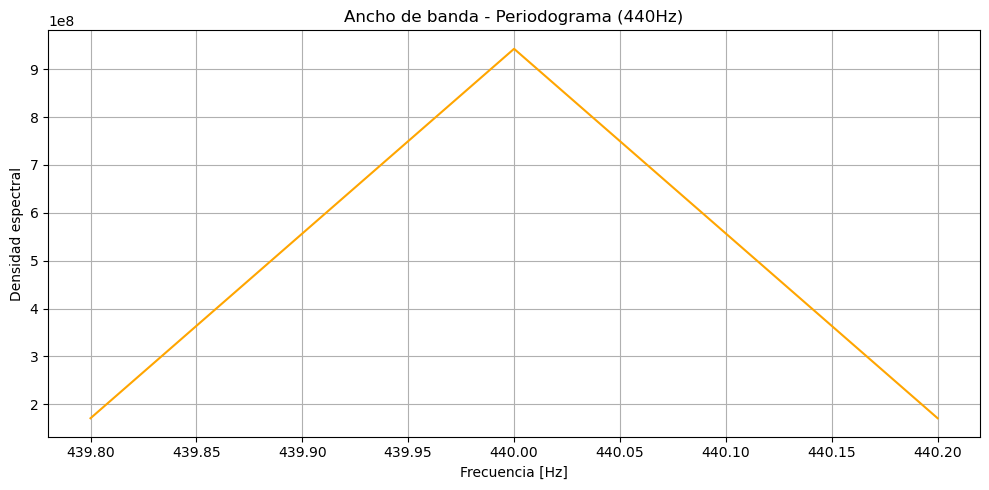

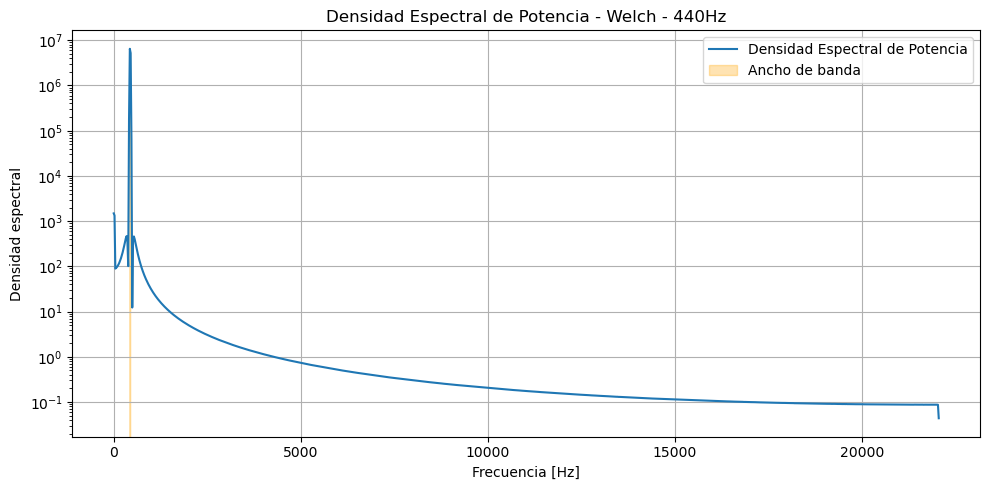

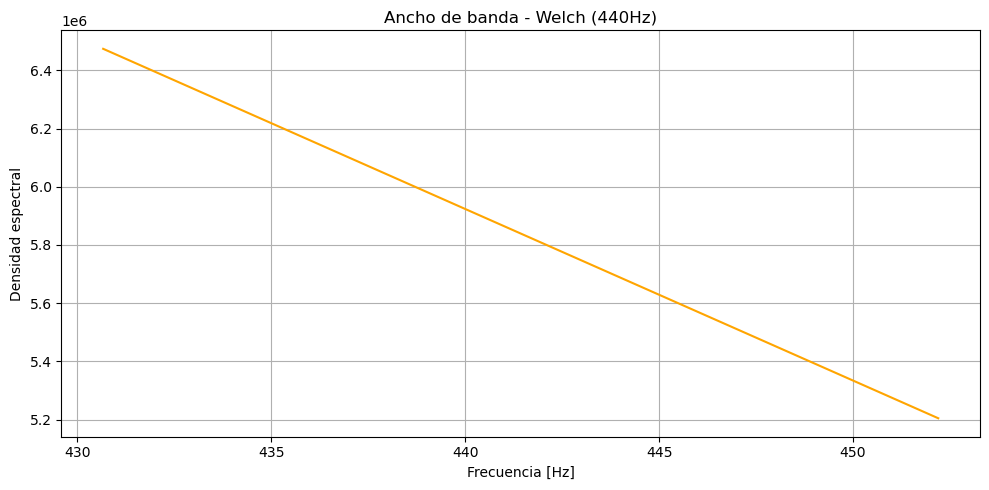

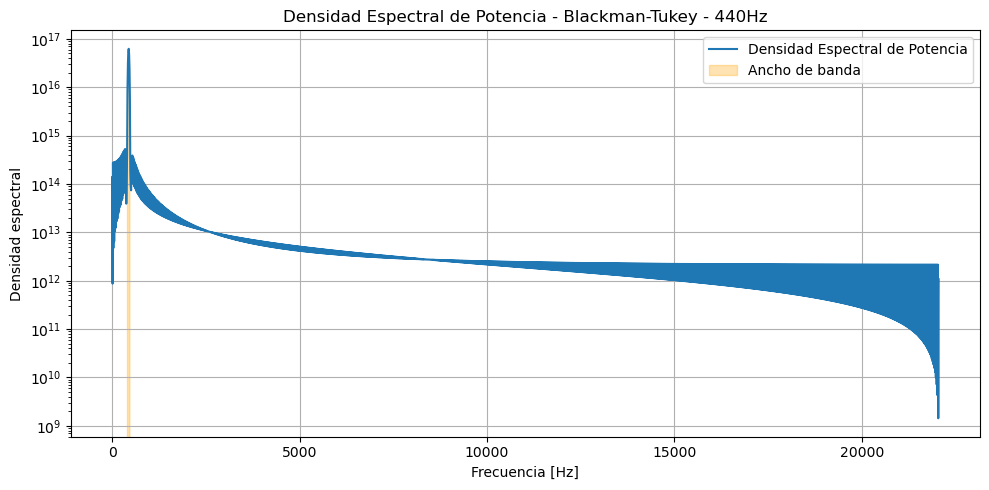

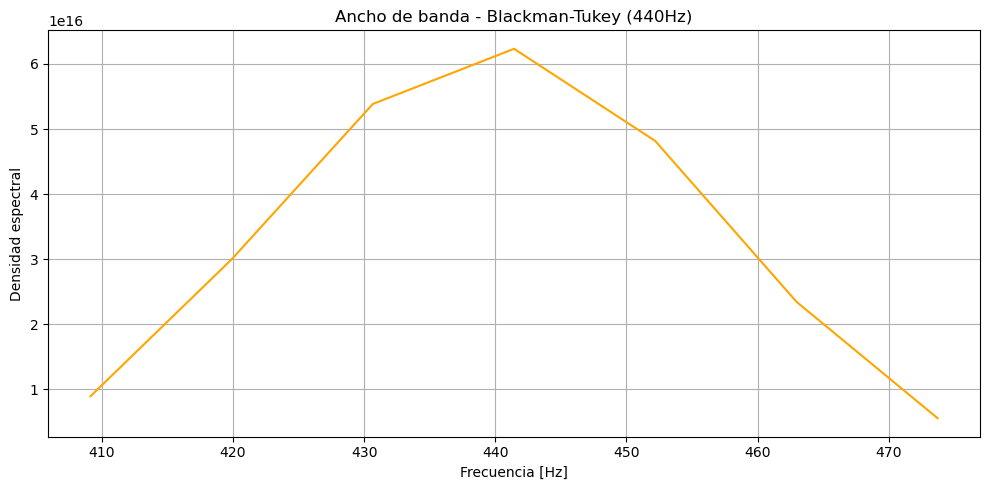

Blackman-Tukey calculado en 3.4 segundos

Resultados del ancho de banda estimado para el 440Hz:

           Método  Frecuencia baja [Hz]  Frecuencia alta [Hz]  \
0    Periodograma            439.800000            440.200000   
1           Welch            430.664062            452.197266   
2  Blackman–Tukey            409.130859            473.730469   

   Ancho de banda [Hz]  
0             0.400000  
1            21.533203  
2            64.599609  

 Tabla guardada en 'resultados/AnchoBanda_440Hz.csv'
 Todos los gráficos guardados en 'resultados/' y mostrados en pantalla


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" 
Densidad Espectral de Potencia del archivo de audio '440Hz.wav'.

Created on Tue Sep 15 18:31:27 2025

@author: Fernando Daniel Fiamberti


Incluye análisis mediante:
- Periodograma ventaneado
- Welch
- Blackman-Tukey
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, welch, windows
from scipy.io import wavfile
import os
import time
import pandas as pd

# ----------------------------
# Cargar archivo WAV (440Hz)
# ----------------------------
wav_file = '440Hz_44100Hz_16bit_05sec.wav'  # archivo de audio base
fs, signal_full = wavfile.read(wav_file)

# Si el audio tiene más de un canal, tomar solo el primer canal
if signal_full.ndim > 1:
    signal_full = signal_full[:, 0]

audio_signal = signal_full
N = len(audio_signal)
print(f"Se usarán todas las {N} muestras del 440Hz para el análisis")
print(f"Frecuencia de muestreo: {fs} Hz")

# ----------------------------
# Crear carpeta de resultados si no existe
# ----------------------------
os.makedirs('resultados', exist_ok=True)

# ----------------------------
# Función para calcular ancho de banda
# ----------------------------
def bandwidth(f, Pxx, threshold=0.05):
    """Devuelve la frecuencia mínima, máxima y ancho de banda donde el PSD supera el umbral relativo."""
    Pxx_norm = Pxx / np.max(Pxx)
    mask = Pxx_norm > threshold
    if np.any(mask):
        f_bw = f[mask]
        return f_bw[0], f_bw[-1], f_bw[-1] - f_bw[0], mask
    else:
        return 0, 0, 0, mask

# ----------------------------
# Función Blackman-Tukey
# ----------------------------
def per_smooth(x, win=1, M=1024, fs=1000, nfft=4096):
    """
    Implementación del método Blackman-Tukey para estimar la PSD.
    Devuelve el espectro unilateral (solo frecuencias positivas)
    
    Parámetros:
    - x: señal de entrada
    - win: tipo de ventana (1=rectangular, 2=Hamming, 3=Hanning, 4=Bartlett, 5=Blackman)
    - M: número de retardos para autocorrelación
    - fs: frecuencia de muestreo
    - nfft: número de puntos FFT
    - f: vector de frecuencias (0 a fs/2)
    - Pxx: PSD estimada unilateral
    """
    x = np.asarray(x).flatten()
    N = len(x)
    x = x - np.mean(x)  # Centrar la señal

    # ----------------------------
    # Autocorrelación
    # ----------------------------
    rxx_full = np.correlate(x, x, mode='full')
    mid = len(rxx_full) // 2
    rxx = rxx_full[mid - M + 1 : mid + M]  # Simétrico alrededor de 0

    # ----------------------------
    # Ventana
    # ----------------------------
    window_types = {1: 'boxcar', 2: 'hamming', 3: 'hann', 4: 'bartlett', 5: 'blackman'}
    w = windows.get_window(window_types.get(win, 'boxcar'), len(rxx))
    rxx_win = rxx * w

    # ----------------------------
    # FFT de la autocorrelación suavizada
    # ----------------------------
    Pxx_full = np.abs(np.fft.fft(rxx_win, nfft))
    
    # 1. Calcular el número de puntos no redundantes (hasta Nyquist)
    n_unique = nfft // 2 + 1
    
    # 2. Tomar la primera mitad y escalar para PSD Unilateral
    Pxx_uni = Pxx_full[:n_unique]
    
    # 3. Aplicar escalado para "densidad de potencia" (multiplicar por 2, excepto 0 y Nyquist)
    # La implementación Blackman-Tukey no siempre usa el factor 1/(fs*N) de forma directa
    # como en periodogram. Para que sea comparable, se escala la parte unilateral.
    Pxx = Pxx_uni.copy()
    Pxx[1:-1] *= 2 # Multiplicar por 2 los puntos intermedios
    
    # 4. Vector de frecuencias para el espectro unilateral
    f = np.linspace(0, fs / 2, n_unique)

    return f, Pxx


# ----------------------------
# 0) Señal de 440Hz en el tiempo
# ----------------------------
plt.figure(figsize=(10, 4))
plt.plot(np.arange(N) / fs, audio_signal, color='blue')
plt.title("Señal de 440Hz en el tiempo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/440Hz_tiempo.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# FFT del 440Hz
# ----------------------------
fft_signal = np.fft.fft(audio_signal, n=N)
f_fft = np.linspace(0, fs / 2, N // 2)
fft_mag = np.abs(fft_signal[:N // 2])

plt.figure(figsize=(10, 4))
plt.semilogy(f_fft, fft_mag)
plt.title("FFT del 440Hz")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/FFT_440Hz.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# 1) Periodograma ventaneado
# ----------------------------
ventana = windows.hamming(N)
f_per, Pxx_per = periodogram(audio_signal, fs=fs, window=ventana, nfft=N, scaling='density')
f_low_per, f_high_per, BW_per, mask_per = bandwidth(f_per, Pxx_per)

plt.figure(figsize=(10, 5))
plt.semilogy(f_per, Pxx_per, label='Densidad Espectral de Potencia')
plt.fill_between(f_per, Pxx_per, where=mask_per, color='orange', alpha=0.3, label='Ancho de banda')
plt.title("Densidad Espectral de Potencia - Periodograma Ventaneado (Hamming) - 440Hz")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_Periodograma_440Hz.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(f_per[mask_per], Pxx_per[mask_per], color='orange')
plt.title("Ancho de banda - Periodograma (440Hz)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Periodograma_440Hz.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# 2) Método de Welch
# ----------------------------
f_welch, Pxx_welch = welch(audio_signal, fs=fs, window='hamming', nperseg=2048, noverlap=1024, scaling='density')
f_low_w, f_high_w, BW_w, mask_w = bandwidth(f_welch, Pxx_welch)

plt.figure(figsize=(10, 5))
plt.semilogy(f_welch, Pxx_welch, label='Densidad Espectral de Potencia')
plt.fill_between(f_welch, Pxx_welch, where=mask_w, color='orange', alpha=0.3, label='Ancho de banda')
plt.title("Densidad Espectral de Potencia - Welch - 440Hz")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_Welch_440Hz.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(f_welch[mask_w], Pxx_welch[mask_w], color='orange')
plt.title("Ancho de banda - Welch (440Hz)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_Welch_440Hz.png', dpi=300)
plt.show()
plt.close()

# ----------------------------
# 3) Blackman-Tukey
# ----------------------------
start_time = time.time()
f_bt, Pxx_bt = per_smooth(audio_signal, win=2, M=1024, fs=fs, nfft=4096)
f_low_bt, f_high_bt, BW_bt, mask_bt = bandwidth(f_bt, Pxx_bt)

plt.figure(figsize=(10, 5))
plt.semilogy(f_bt, Pxx_bt, label='Densidad Espectral de Potencia')
plt.fill_between(f_bt, Pxx_bt, where=mask_bt, color='orange', alpha=0.3, label='Ancho de banda')
plt.title("Densidad Espectral de Potencia - Blackman-Tukey - 440Hz")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/Densidad_Espectral_de_Potencia_BlackmanTukey_440Hz.png', dpi=300)
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(f_bt[mask_bt], Pxx_bt[mask_bt], color='orange')
plt.title("Ancho de banda - Blackman-Tukey (440Hz)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral")
plt.grid(True)
plt.tight_layout()
plt.savefig('resultados/AnchoBanda_BlackmanTukey_440Hz.png', dpi=300)
plt.show()
plt.close()

end_time = time.time()
print(f"Blackman-Tukey calculado en {end_time - start_time:.1f} segundos")

# ----------------------------
# Tabla de anchos de banda
# ----------------------------
tabla_bw = pd.DataFrame({
    "Método": ["Periodograma", "Welch", "Blackman–Tukey"],
    "Frecuencia baja [Hz]": [f_low_per, f_low_w, f_low_bt],
    "Frecuencia alta [Hz]": [f_high_per, f_high_w, f_high_bt],
    "Ancho de banda [Hz]": [BW_per, BW_w, BW_bt]
})

print("\nResultados del ancho de banda estimado para el 440Hz:\n")
print(tabla_bw)
tabla_bw.to_csv('resultados/AnchoBanda_440Hz.csv', index=False, float_format='%.3f')
print("\n Tabla guardada en 'resultados/AnchoBanda_440Hz.csv'")
print(" Todos los gráficos guardados en 'resultados/' y mostrados en pantalla")
